### <a href="#1">1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).</a>

### <a href="#2">2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.</a>

In [1]:
import matplotlib.pyplot as plt
import random
from sklearn import model_selection
from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

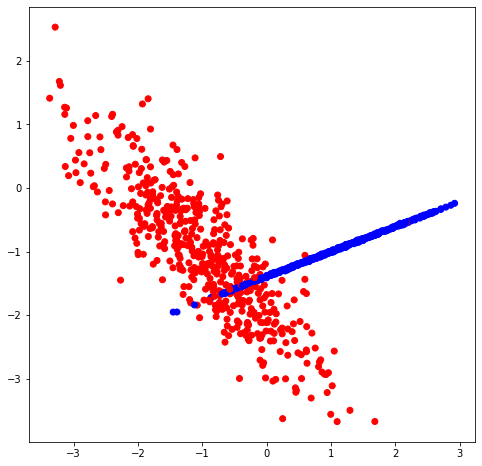

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет качества

def quality(left_labels, right_labels, current_criterion_information):
   # print(f"criterion_information = {criterion_information.__name__}")
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criterion_information - p * criterion_information(left_labels) - (1 - p) * criterion_information(right_labels)

In [7]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_criterion_information = criterion_information(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion_information)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

__<div id=1>Реализация критерия останова "Глубина дерева""</div>__

Для реализации критерия останова "Глубина дерева" в рекуррентную функцию build_tree добавлен еще один параметр tree_depth, через который передается число характеризующее глубину дерева.

In [9]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, tree_depth):
    if tree_depth == 0:
        print(f'Останов, ограничение по глубине дерева')
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        print(f'Останов, нет прироста качества')
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    tree_depth -= 1
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,tree_depth)
    false_branch = build_tree(false_data, false_labels,tree_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [21]:
# Расчет критерия Джини

def gini(labels):
        #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2 
    return impurity


__<div id=2>Реализация критерия "энтропия Шеннона"</div>__

In [13]:
# Расчет критерия энтропия Шеннона

def shannon_entropy(labels):    
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    res = 0
    for label in classes:
        p = classes[label] / len(labels)
        res += p*np.log2(p) 
    return -res

In [14]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [15]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [16]:
criterion_information = None

In [17]:
 # Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                                 classification_labels, 
                                                                                                test_size = 0.3,             
                                                                                                 random_state = 1)

def model(criterion, tree_depth = 5):
            global criterion_information, train_data, test_data, train_labels, test_labels
            criterion_information = criterion 
            
           
            
            
            my_tree = build_tree(train_data, train_labels, tree_depth)
            # Построим дерево по обучающей выборке
            
            
            # Получим ответы для обучающей выборки 
            train_answers = predict(train_data, my_tree)

            # И получим ответы для тестовой выборки
            answers = predict(test_data, my_tree)

            # Точность на обучающей выборке
            train_accuracy = accuracy_metric(train_labels, train_answers)
            print(f'train_accuracy = {train_accuracy}')

            # Точность на тестовой выборке
            test_accuracy = accuracy_metric(test_labels, answers)
            print(f'test_accuracy = {test_accuracy}')

            
            
            plt.figure(figsize = (16, 7))
            plt.suptitle(f'Критерий информативности {criterion_information.__name__}')

            # график обучающей выборки
            plt.subplot(1,2,1)
            xx, yy = get_meshgrid(train_data)
            mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
            plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
            plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
            plt.title(f'Train accuracy={train_accuracy:.2f}')

            # график тестовой выборки
            plt.subplot(1,2,2)
            plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
            plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
            plt.title(f'Test accuracy={test_accuracy:.2f}')
            
            # Напечатаем ход нашего дерева    
            print_tree(my_tree)



In [18]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, ограничение по глубине дерева
Останов, ограничение по глубине дерева
Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, ограничение по глубине дерева
Останов, ограничение по глубине дерева
Останов, нет прироста в качества
Останов, нет прироста в качества
train_accuracy = 97.14285714285714
test_accuracy = 93.66666666666667
Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6646404646216442
    --> True:
      Индекс 0
      Порог -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.40118216125291906
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 1
  --> False:
    Прогноз: 

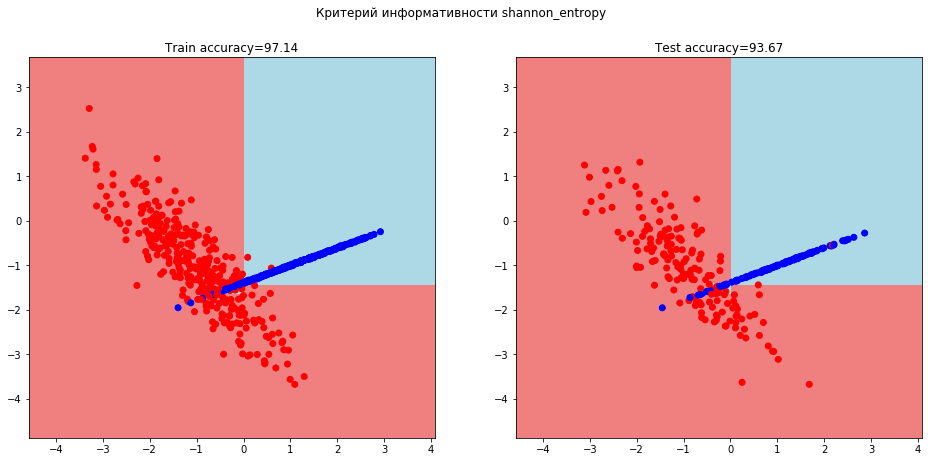

In [19]:
model(shannon_entropy, tree_depth=5)

Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, ограничение по глубине дерева
Останов, ограничение по глубине дерева
Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, нет прироста в качества
Останов, ограничение по глубине дерева
Останов, ограничение по глубине дерева
Останов, нет прироста в качества
train_accuracy = 97.14285714285714
test_accuracy = 93.66666666666667
Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6646404646216442
    --> True:
      Индекс 0
      Порог -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.40118216125291906
        --> True:
          Прогноз: 0
        --> False:
          Прог

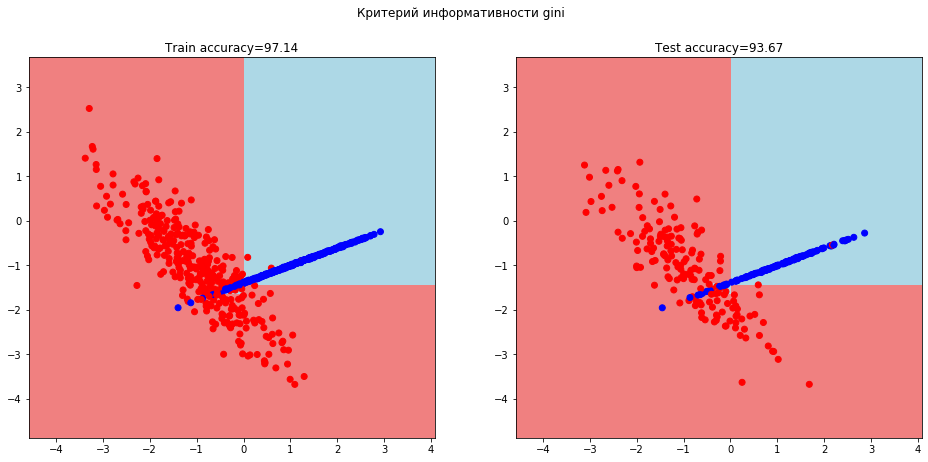

In [22]:
model(gini, tree_depth=5)

__Вывод__

Сравнивая качества классификаций, выпаленных по критериям разбиения Джини, и Энтропия можно сделать вывод, что качество не меняется.  Качество не меняется при разных значениях параметра n_samples, функции datasets.make_classification.